# Підготовка даних

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50

In [380]:
labelEncoder = LabelEncoder()

In [381]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [382]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
ROOT_DIR = './data/Chess'
IMAGE_SHAPE = (64, 64)
EPOCHS = 100
BATCH_SIZE = 64
TEST_SIZE = 0.2
AUGMENTED_IMAGES = 50
MAX_COLOR = 255.0

In [384]:
subfolders = [folder for folder in os.scandir(ROOT_DIR) if folder.is_dir()]

subfolders

[<DirEntry 'Bishop'>,
 <DirEntry 'Rook'>,
 <DirEntry 'Pawn'>,
 <DirEntry 'Knight'>,
 <DirEntry 'King'>,
 <DirEntry 'Queen'>]

In [385]:
images = []
labels = []
categories = []

for folder in subfolders:
    fnames = os.listdir(folder.path)
    categories.append(folder.name)

    for fname in fnames:
        path = os.path.join(folder.path, fname)
        image = cv2.imread(path)
        
        if image is None:
            print(f"Image {path} could not be read.")
            continue
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SHAPE)
        image = image / MAX_COLOR

        images.append(image)
        labels.append(folder.name)

        generator = datagen.flow(np.expand_dims(image, axis=0) , batch_size=1)
        
        for _ in range(AUGMENTED_IMAGES):
            augmented_image = next(generator)[0]
            
            images.append(augmented_image)
            labels.append(folder.name)

    print('Total images in folder: ', folder.path, len(fnames))

images = np.array(images)
labels = np.array(labels)

total_images = len(images)

print('Total images: ', total_images, categories)

Image ./data/Chess/Bishop/00000095.gif could not be read.
Total images in folder:  ./data/Chess/Bishop 87
Total images in folder:  ./data/Chess/Rook 102
Total images in folder:  ./data/Chess/Pawn 107
Total images in folder:  ./data/Chess/Knight 106
Total images in folder:  ./data/Chess/King 76
Total images in folder:  ./data/Chess/Queen 78
Total images:  28305 ['Bishop', 'Rook', 'Pawn', 'Knight', 'King', 'Queen']


In [386]:
N_CLASSES = len(categories)
N_CLASSES

6

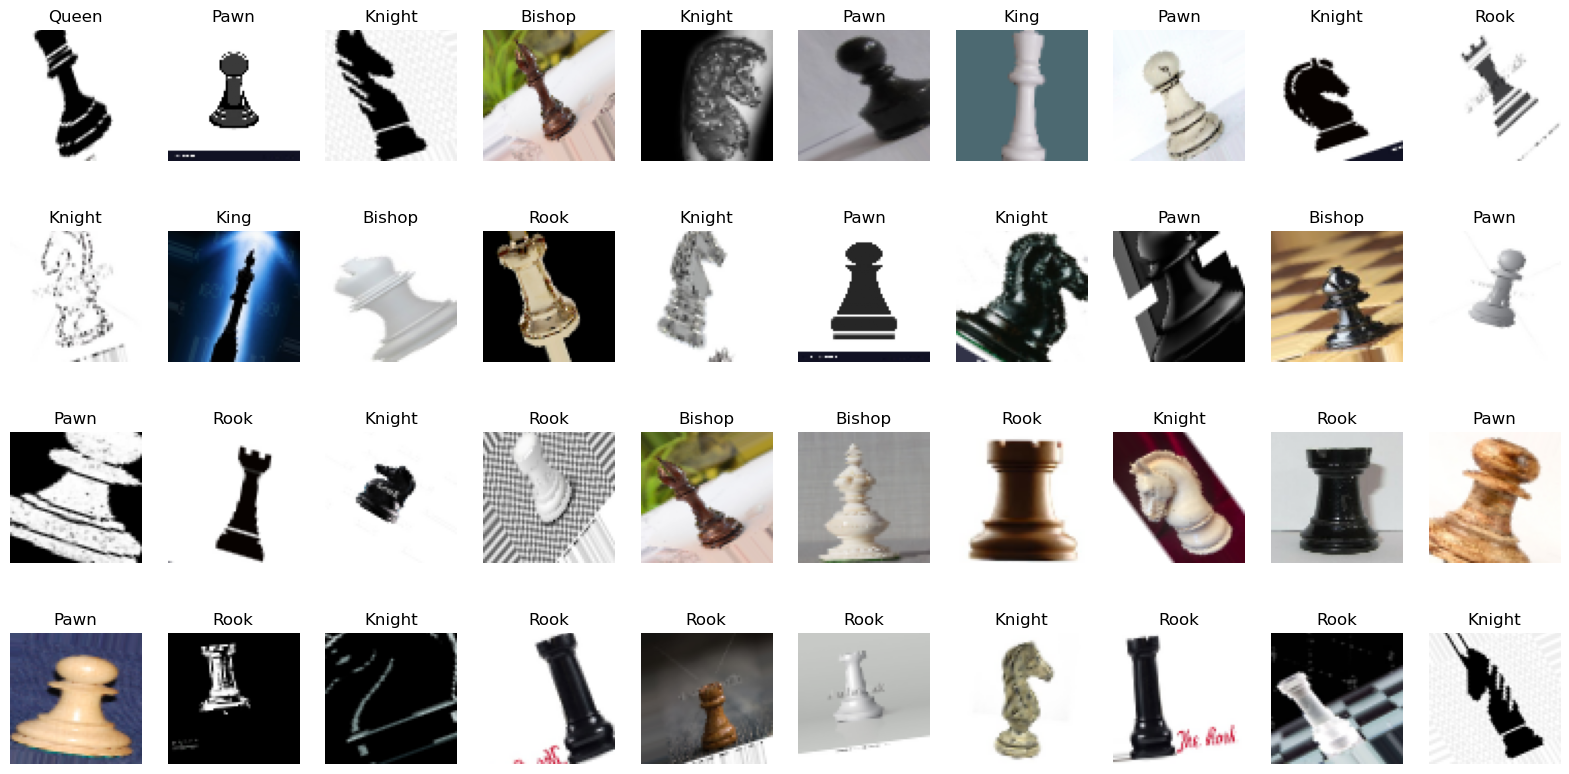

In [387]:
plt.figure(figsize=(20, 10))

for cnt, idx in enumerate(np.random.randint(0, len(images), 40)):
    plt.subplot(4, 10, cnt + 1)
    plt.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
    plt.title(labels[idx])
    plt.axis(False)

# Нормалізація даних

In [388]:
labels_encoded = labelEncoder.fit_transform(labels)

(Text(0.5, 0, 'Traffic Sign ID'), Text(0, 0.5, 'Counts'))

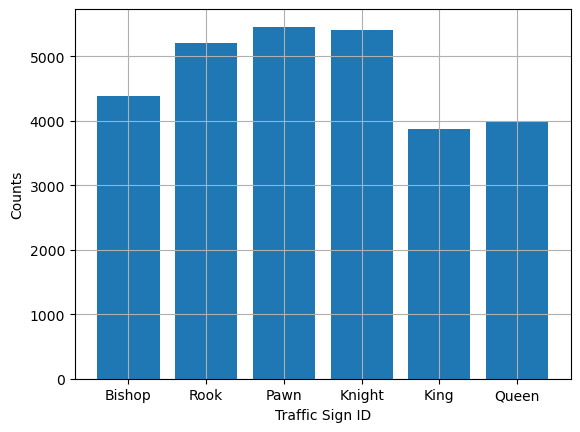

In [389]:
hist = Counter(labels)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('Traffic Sign ID'), plt.ylabel('Counts')

# Перетворення міток у формат one-hot encoding

In [390]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=TEST_SIZE, shuffle=True)

y_train = to_categorical(y_train, num_classes=N_CLASSES)
y_test = to_categorical(y_test, num_classes=N_CLASSES)

len(x_train), len(y_train), len(x_test), len(y_test)


(22644, 22644, 5661, 5661)

# Створення базової моделі CNN

In [417]:
INPUT_SHAPE = (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)

In [ ]:
model = Sequential([
    Input(shape=INPUT_SHAPE), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 6)              │       110,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,846 (796.27 KB)

 Trainable params: 203,846 (796.27 KB)

 Non-trainable params: 0 (0.00 B)

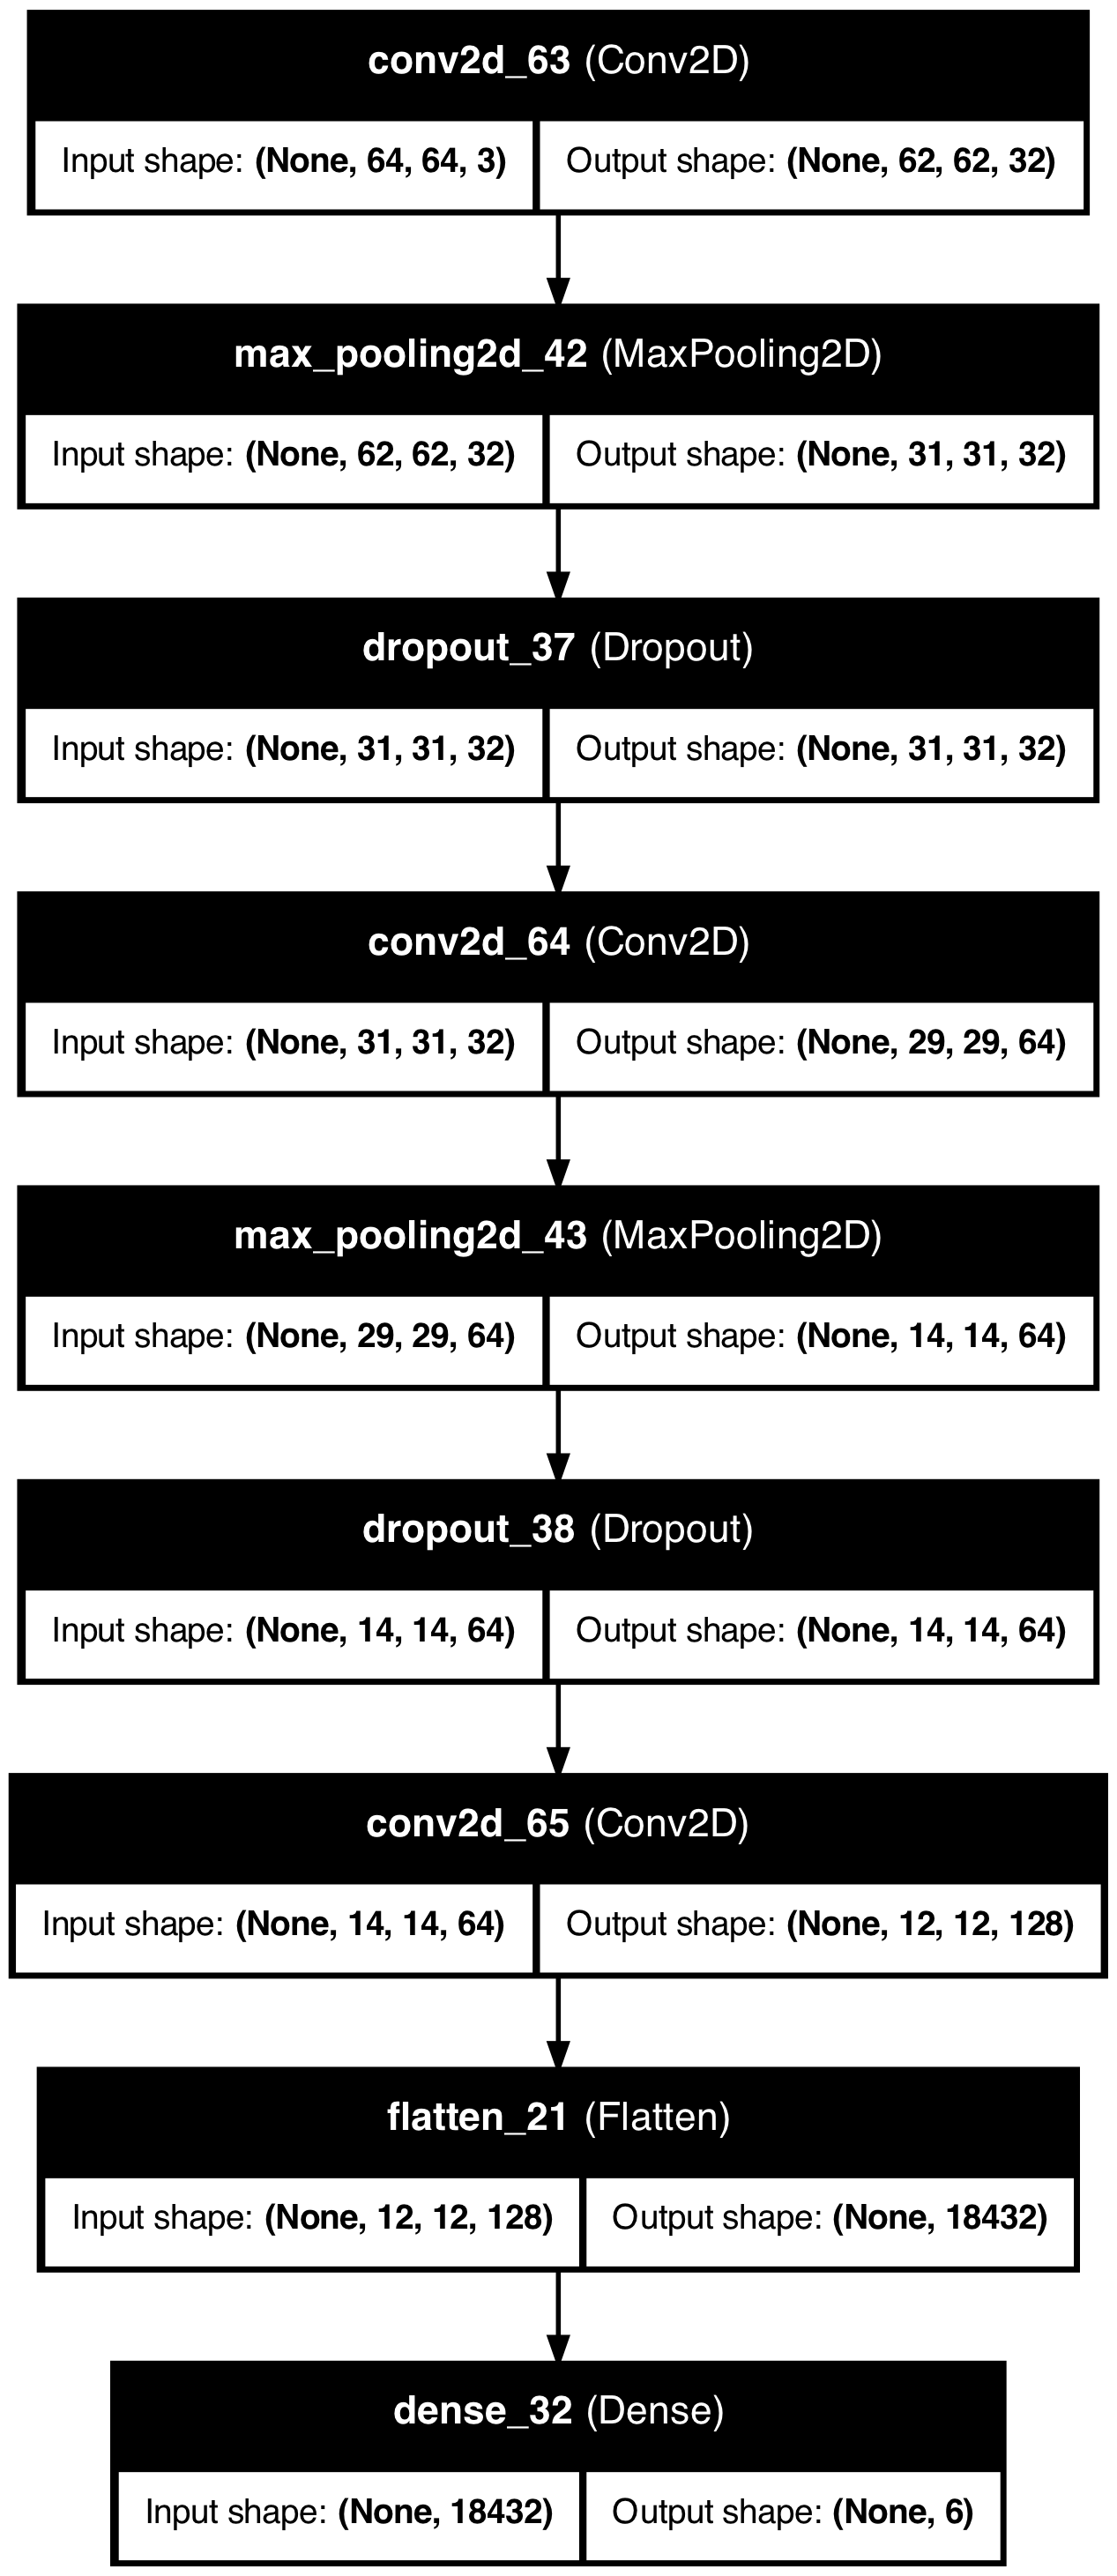

In [402]:
model.summary()

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


In [403]:
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), batch_size=BATCH_SIZE) #, callbacks=[earlyStopping])

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.2440 - loss: 1.7400 - val_accuracy: 0.4450 - val_loss: 1.4284
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4868 - loss: 1.3130 - val_accuracy: 0.6001 - val_loss: 1.0446
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6493 - loss: 0.9495 - val_accuracy: 0.6854 - val_loss: 0.8588
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7426 - loss: 0.6950 - val_accuracy: 0.7559 - val_loss: 0.6845
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8100 - loss: 0.5306 - val_accuracy: 0.7734 - val_loss: 0.6425
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8477 - loss: 0.4199 - val_accuracy: 0.7923 - val_loss: 0.6045
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8807 - loss: 0.3390 - val_accuracy: 0.8124 - val_loss: 0.5462
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9079 - loss: 0

In [422]:
def draw_history(history):
      history_data = history.history
      epochs = range(len(history_data['loss']))
      plt.figure(figsize=(20, 8))
      plt.subplot(121)
      plt.plot(epochs, history_data['loss'], '.-', epochs, history_data['val_loss'], '.-')
      plt.grid(True)
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.legend(['Train', 'Validation'])

      plt.subplot(122)
      plt.plot(epochs, history_data['accuracy'], '.-', epochs, history_data['val_accuracy'], '.-')
      plt.grid(True)
      plt.xlabel('epochs')
      plt.ylabel('Accuracy')
      plt.legend(['Train', 'Validation'])

      print('Accuracy:', (history_data['accuracy'][-1])) 
      print('Loss:', (history_data['loss'][-1]))

Accuracy: 0.9884737730026245
Loss: 0.04473323002457619


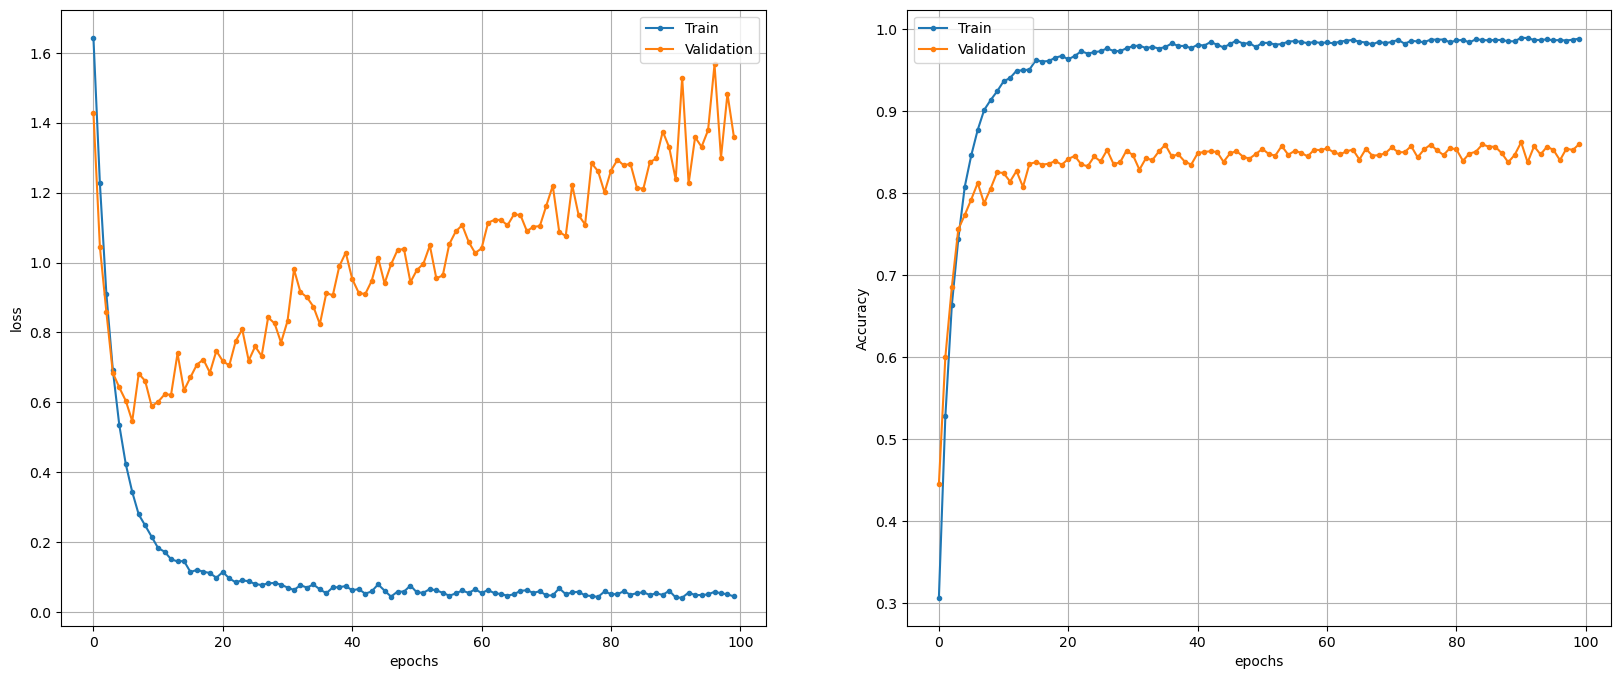

In [423]:
draw_history(history)

First run (original set)
![First](history/1.png)

Second run (early stopping)
![Second](history/2.png)

In [406]:
loss, metric = model.evaluate(x_test, y_test)

print('Test loss:', loss)
print('Test metric:', metric)

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8588 - loss: 1.3629
Test loss: 1.358924388885498
Test metric: 0.8600953817367554


In [411]:
predictions = model.predict(x_test)
prediction = np.argmax(predictions, axis=1)
verification = np.argmax(y_test, axis=1)

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
prediction == verification
correct = np.sum(prediction == verification)
total = len(prediction)

print('Correct predictions:', correct)
print('Incorrect predictions:', total - correct)
print('Total predictions:', total)
print('Accuracy:', correct / total)

Correct predictions: 4869
Incorrect predictions: 792
Total predictions: 5661
Accuracy: 0.8600953895071543


# Використання попередньо навчених моделей VGG16 та ResNet

# Завантаження попередньо навчених моделей без верхніх шарів

In [ ]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


# Додавання верхніх шарів для класифікації

In [ ]:
def create_model(base_model):
    outputs = base_model.output
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dense(128, activation='relu')(outputs)
    outputs = Dense(N_CLASSES, activation='softmax')(outputs)
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

In [ ]:
model_vgg = create_model(base_model_vgg)
model_resnet = create_model(base_model_resnet)

# Компіляція моделей

In [ ]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Навчання моделей

In [ ]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)
history_resnet = model_resnet.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 314s 887ms/step - accuracy: 0.9454 - loss: 0.1679 - val_accuracy: 0.9244 - val_loss: 0.2198
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 307s 867ms/step - accuracy: 0.9613 - loss: 0.1161 - val_accuracy: 0.9419 - val_loss: 0.1833
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 305s 862ms/step - accuracy: 0.9703 - loss: 0.0883 - val_accuracy: 0.9550 - val_loss: 0.1523
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 308s 870ms/step - accuracy: 0.9739 - loss: 0.0828 - val_accuracy: 0.8935 - val_loss: 0.3707
Epoch 5/10
 30/354 ━━━━━━━━━━━━━━━━━━━━ 4:27 825ms/step - accuracy: 0.9206 - loss: 0.2401

In [ ]:
draw_history(history_resnet)

In [ ]:
draw_history(history_vgg)

# Використання моделі YOLO для детекції об'єктів

# Завантаження попередньо навчених вагів YOLO та конфігурації

In [ ]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Функція для завантаження зображення та детекції об'єктів

In [ ]:
'''
def detect_objects(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label + " " + str(round(confidence, 2)), (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, color, 3)
    
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
'''

# Використання функції для детекції об'єктів

In [ ]:
# detect_objects("")

# Оцінка моделей

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)